In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")

In [3]:
import random as py_random
import matplotlib.pyplot as plt
import pandas as pd
import models
import warnings
warnings.filterwarnings('ignore')

## Table of Contents

* [Context](#context)
* [ETL](#etl)
* [Single Variable EDA](#eda)
* [Pairwise EDA](#pairwise)
* [Correlations](#correlations)
* [Linear Regression Model](#linear)
* [Decision Tree](#tree)
* [Random Forest](#forest)
* [Executive Summary](#summary)

<a id="context"></a>
### Context

The real estate markets, like those in Sydney and Melbourne, present an interesting opportunity for data analysts to analyze and predict where property prices are moving towards. Prediction of property prices is becoming increasingly important and beneficial. Property prices are a good indicator of both the overall market condition and the economic health of a country. Considering the data provided, we are wrangling a large set of property sales records stored in an unknown format and with unknown data quality issues

Based on the information, we can see the dataset tries to study hoursing price based on several features of a house. The analysis below will investigate on how different factors impact housing price

<a id="etl"></a>
### ETL

We will start with load in the data

In [4]:
df = pd.read_csv('data.csv')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


Next we will convert zip code to longtitude and latitude so that it's easier to interpret and analyze

In [5]:
import zipcodes

df['zip'] = [x[3:] for x in df['statezip'] ]
df['location'] = [zipcodes.matching(x) for x in df['zip'] ]
df['lat'] = [x[0]['lat'] for x in df['location'] ]
df['long'] = [abs(x[0]['long']) for x in df['location'] ]

df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,street,city,statezip,country,zip,location,lat,long
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,...,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,98133,"[{'zip_code': '98133', 'zip_code_type': 'STAND...",47.73,122.34
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,...,1921,0,709 W Blaine St,Seattle,WA 98119,USA,98119,"[{'zip_code': '98119', 'zip_code_type': 'STAND...",47.63,122.37
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,...,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,98042,"[{'zip_code': '98042', 'zip_code_type': 'STAND...",47.36,122.10
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,...,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,98008,"[{'zip_code': '98008', 'zip_code_type': 'STAND...",47.60,122.11
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,...,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,98052,"[{'zip_code': '98052', 'zip_code_type': 'STAND...",47.68,122.12


Form the dataset to be analyzed and take a look at dataset info

In [6]:
data = df[["price","bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","sqft_above","sqft_basement","yr_built","yr_renovated","lat","long"]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 15 columns):
price            4600 non-null float64
bedrooms         4600 non-null float64
bathrooms        4600 non-null float64
sqft_living      4600 non-null int64
sqft_lot         4600 non-null int64
floors           4600 non-null float64
waterfront       4600 non-null int64
view             4600 non-null int64
condition        4600 non-null int64
sqft_above       4600 non-null int64
sqft_basement    4600 non-null int64
yr_built         4600 non-null int64
yr_renovated     4600 non-null int64
lat              4600 non-null float64
long             4600 non-null float64
dtypes: float64(6), int64(9)
memory usage: 539.1 KB


Take a look at general stats of the varaibles

In [7]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261,47.560878,122.199598
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536,0.134912,0.160639
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000,47.100000,121.330000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000,47.490000,122.100000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000,47.580000,122.220000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000,47.670000,122.320000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000,47.750000,122.450000


There are some price = 0 which we would like to exclude from this analysis

In [8]:
data = data[data.price != 0]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4551 entries, 0 to 4599
Data columns (total 15 columns):
price            4551 non-null float64
bedrooms         4551 non-null float64
bathrooms        4551 non-null float64
sqft_living      4551 non-null int64
sqft_lot         4551 non-null int64
floors           4551 non-null float64
waterfront       4551 non-null int64
view             4551 non-null int64
condition        4551 non-null int64
sqft_above       4551 non-null int64
sqft_basement    4551 non-null int64
yr_built         4551 non-null int64
yr_renovated     4551 non-null int64
lat              4551 non-null float64
long             4551 non-null float64
dtypes: float64(6), int64(9)
memory usage: 568.9 KB


In [10]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long
count,4.551000e+03,4551.000000,4551.000000,4551.000000,4.551000e+03,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000
mean,5.579059e+05,3.394639,2.155021,2132.372226,1.483528e+04,1.512195,0.006592,0.234674,3.449352,1822.221710,310.150516,1970.795649,808.564052,47.561158,122.199747
std,5.639299e+05,0.904595,0.776351,955.949708,3.596408e+04,0.538531,0.080932,0.765373,0.675160,854.452888,461.987629,29.760073,979.421487,0.134845,0.160573
min,7.800000e+03,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000,47.100000,121.330000
25%,3.262643e+05,3.000000,1.750000,1460.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000,47.490000,122.100000
50%,4.650000e+05,3.000000,2.250000,1970.000000,7.680000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000,47.580000,122.220000
75%,6.575000e+05,4.000000,2.500000,2610.000000,1.097800e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,600.000000,1997.000000,1999.000000,47.670000,122.320000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000,47.750000,122.450000


Now the dataset is cleaned and we are ready to start our analysis.

<a id="eda"></a>
### Single Variable EDA

#### price

In [11]:
data.price.describe()

count    4.551000e+03
mean     5.579059e+05
std      5.639299e+05
min      7.800000e+03
25%      3.262643e+05
50%      4.650000e+05
75%      6.575000e+05
max      2.659000e+07
Name: price, dtype: float64

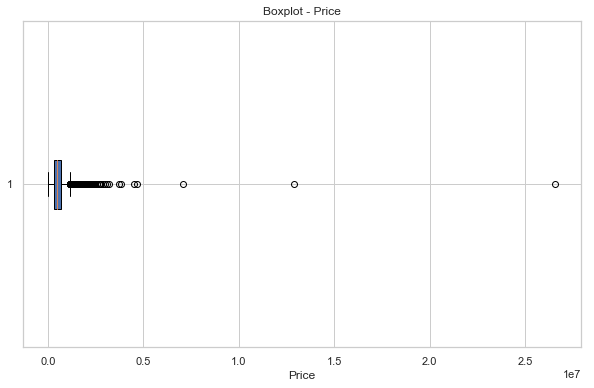

In [12]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.boxplot(data.price, patch_artist=True, zorder=1, vert=False)
axes.set_xlabel("Price")
axes.set_title("Boxplot - Price")
plt.show()
plt.close()

There seem to be several extremely big values, we will treat them as outlier and exclude them from this analysis

In [13]:
data = data[data.price < 5000000]

In [14]:
data.price.describe()

count    4.548000e+03
mean     5.480383e+05
std      3.553765e+05
min      7.800000e+03
25%      3.260750e+05
50%      4.650000e+05
75%      6.572000e+05
max      4.668000e+06
Name: price, dtype: float64

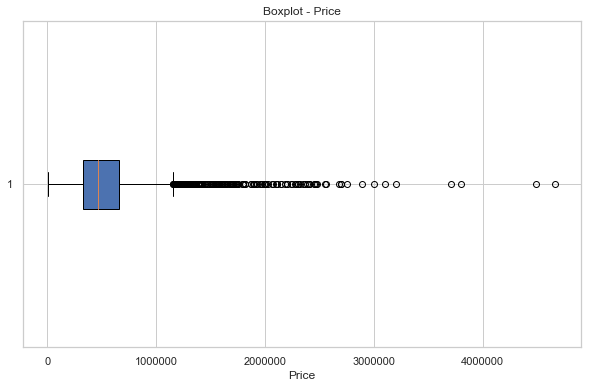

In [15]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.boxplot(data.price, patch_artist=True, zorder=1, vert=False)
axes.set_xlabel("Price")
axes.set_title("Boxplot - Price")
plt.show()
plt.close()

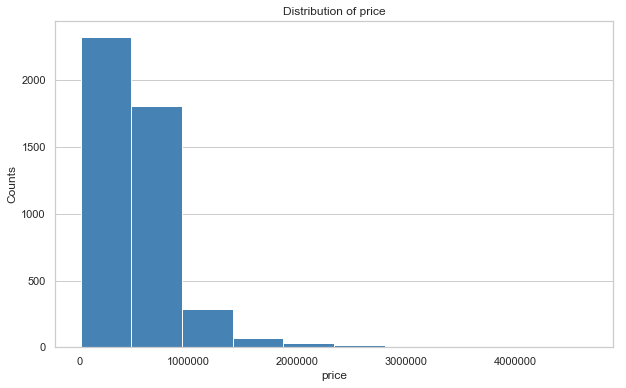

In [16]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.price, color="steelblue")
axes.set_title("Distribution of price")
axes.set_xlabel("price")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the price seems to be log normal with mean at 5.48e05

#### bedrooms

In [17]:
data.bedrooms.describe()

count    4548.000000
mean        3.394459
std         0.904542
min         0.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: bedrooms, dtype: float64

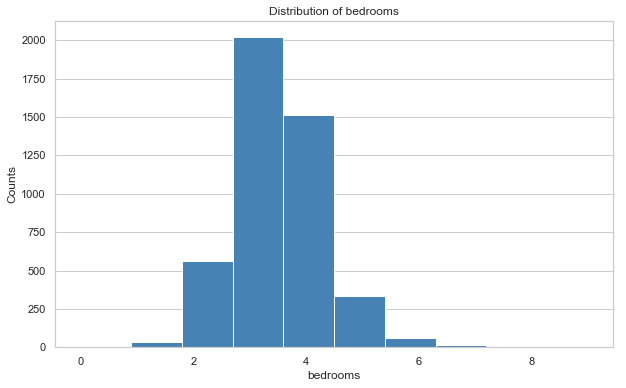

In [18]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.bedrooms, color="steelblue")
axes.set_title("Distribution of bedrooms")
axes.set_xlabel("bedrooms")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Bedrooms has a normal dsitribution with range 0 to 9

#### bathrooms

In [19]:
data.bathrooms.describe()

count    4548.000000
mean        2.154464
std         0.775808
min         0.000000
25%         1.750000
50%         2.250000
75%         2.500000
max         8.000000
Name: bathrooms, dtype: float64

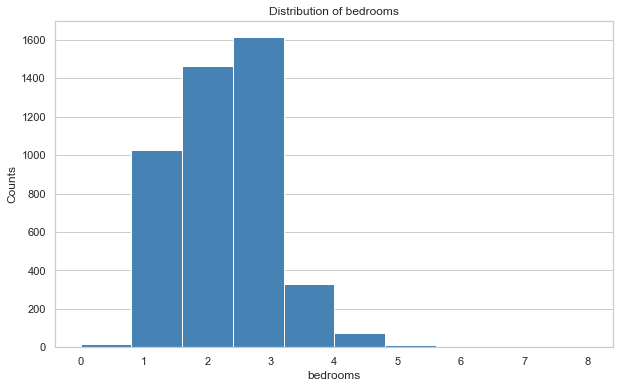

In [20]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.bathrooms, color="steelblue")
axes.set_title("Distribution of bedrooms")
axes.set_xlabel("bedrooms")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Most of the house has less than 4 bedrooms

#### sqft_living

In [21]:
data.sqft_living.describe()

count     4548.000000
mean      2130.830255
std        948.940535
min        370.000000
25%       1460.000000
50%       1970.000000
75%       2610.000000
max      13540.000000
Name: sqft_living, dtype: float64

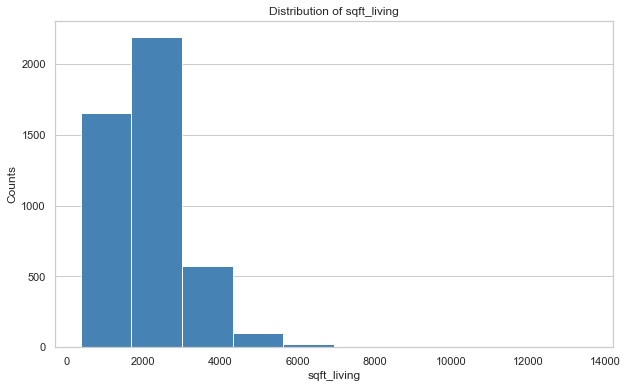

In [22]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.sqft_living, color="steelblue")
axes.set_title("Distribution of sqft_living")
axes.set_xlabel("sqft_living")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the sqft_living seems to be log normal with mean at 2130

#### sqft_lot

In [23]:
data.sqft_lot.describe()

count    4.548000e+03
mean     1.483264e+04
std      3.597421e+04
min      6.380000e+02
25%      5.000000e+03
50%      7.680000e+03
75%      1.096400e+04
max      1.074218e+06
Name: sqft_lot, dtype: float64

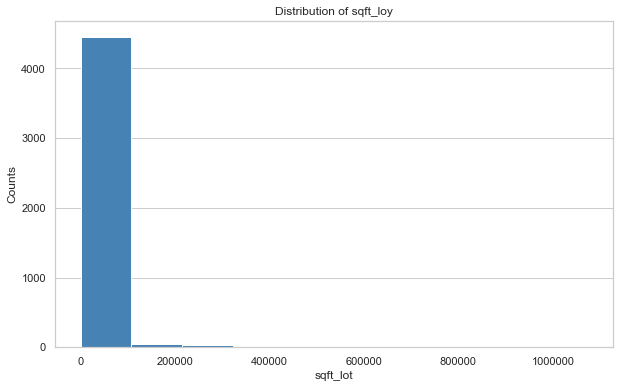

In [24]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.sqft_lot, color="steelblue")
axes.set_title("Distribution of sqft_loy")
axes.set_xlabel("sqft_lot")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the sqft_living seems to be log normal with mean at 15000

#### floors

In [25]:
data.floors.describe()

count    4548.000000
mean        1.512313
std         0.538553
min         1.000000
25%         1.000000
50%         1.500000
75%         2.000000
max         3.500000
Name: floors, dtype: float64

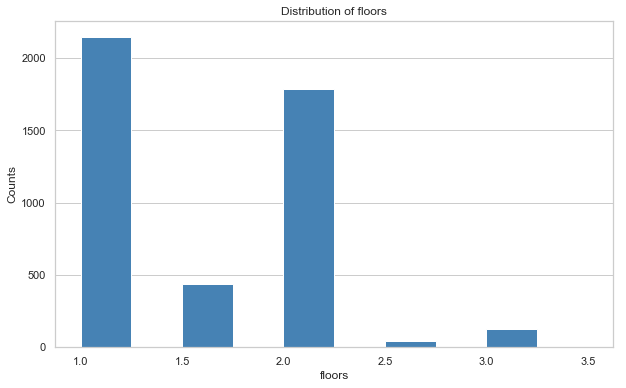

In [26]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.floors, color="steelblue")
axes.set_title("Distribution of floors")
axes.set_xlabel("floors")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Most of the house has 1 or 2 floors

#### waterfront

In [27]:
data.waterfront.describe()

count    4548.000000
mean        0.006376
std         0.079606
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: waterfront, dtype: float64

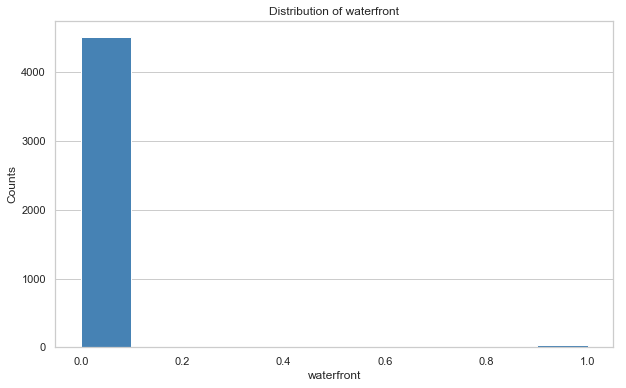

In [28]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.waterfront, color="steelblue")
axes.set_title("Distribution of waterfront")
axes.set_xlabel("waterfront")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Most of the house is not waterfront

#### view

In [29]:
data.view.describe()

count    4548.000000
mean        0.234389
std         0.765161
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: view, dtype: float64

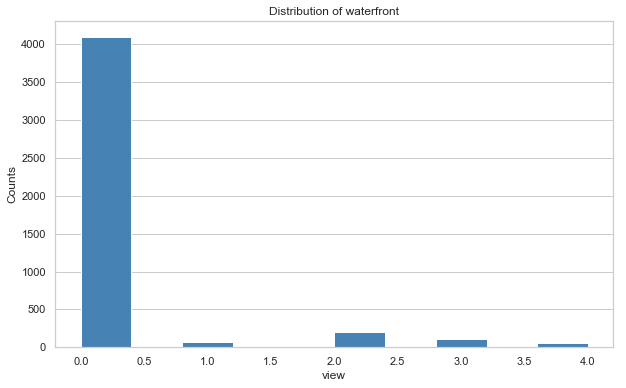

In [30]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.view, color="steelblue")
axes.set_title("Distribution of waterfront")
axes.set_xlabel("view")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Most of the house doesn't have special view

#### condition

In [31]:
data.condition.describe()

count    4548.000000
mean        3.449428
std         0.675267
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: condition, dtype: float64

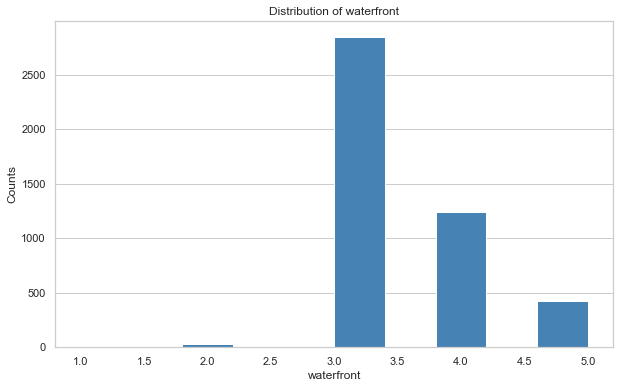

In [32]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.condition, color="steelblue")
axes.set_title("Distribution of waterfront")
axes.set_xlabel("waterfront")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Most common condition is 3

#### sqft_above

In [33]:
data.sqft_above.describe()

count    4548.000000
mean     1821.134785
std       850.245157
min       370.000000
25%      1190.000000
50%      1590.000000
75%      2300.000000
max      9410.000000
Name: sqft_above, dtype: float64

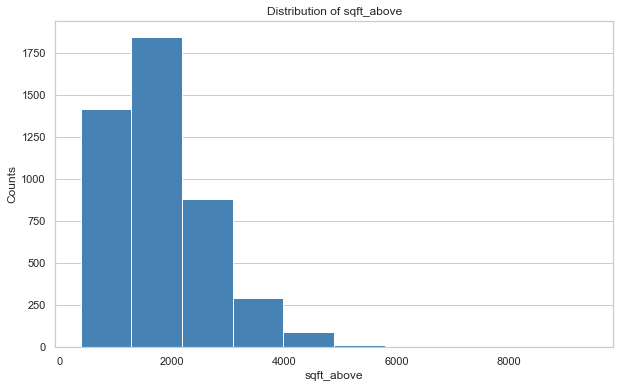

In [34]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.sqft_above, color="steelblue")
axes.set_title("Distribution of sqft_above")
axes.set_xlabel("sqft_above")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the sqft_above seems to be log normal with mean at 1821

#### sqft_basement

In [35]:
data.sqft_basement.describe()

count    4548.000000
mean      309.695471
std       461.090009
min         0.000000
25%         0.000000
50%         0.000000
75%       600.000000
max      4820.000000
Name: sqft_basement, dtype: float64

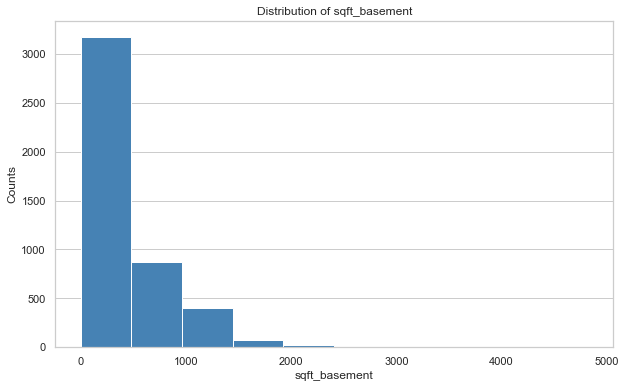

In [36]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.sqft_basement, color="steelblue")
axes.set_title("Distribution of sqft_basement")
axes.set_xlabel("sqft_basement")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the sqft_basement seems to be log normal with mean at 309

#### yr_built

In [37]:
data.yr_built.describe()

count    4548.000000
mean     1970.801011
std        29.763916
min      1900.000000
25%      1951.000000
50%      1976.000000
75%      1997.000000
max      2014.000000
Name: yr_built, dtype: float64

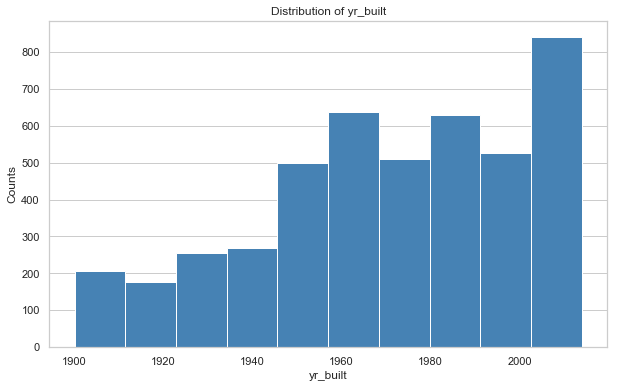

In [38]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.yr_built, color="steelblue")
axes.set_title("Distribution of yr_built")
axes.set_xlabel("yr_built")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

House built increases over time

#### latitude

In [39]:
data.lat.describe()

count    4548.000000
mean       47.561163
std         0.134860
min        47.100000
25%        47.490000
50%        47.580000
75%        47.670000
max        47.750000
Name: lat, dtype: float64

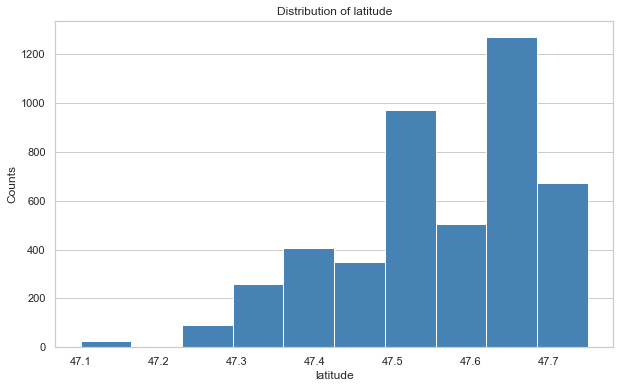

In [40]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.lat, color="steelblue")
axes.set_title("Distribution of latitude")
axes.set_xlabel("latitude")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

There seems to be some latitude more popular for building house

#### longtitude

In [41]:
data.long.describe()

count    4548.000000
mean      122.199703
std         0.160599
min       121.330000
25%       122.100000
50%       122.220000
75%       122.320000
max       122.450000
Name: long, dtype: float64

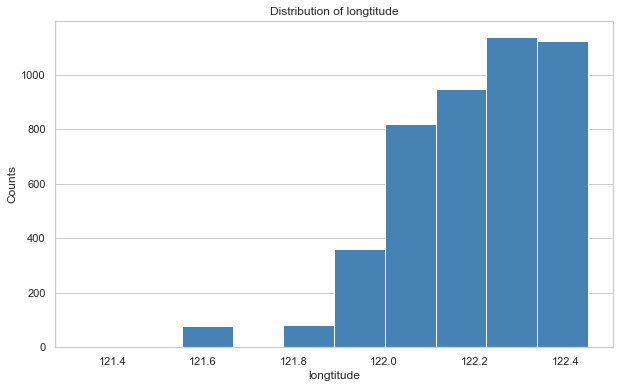

In [42]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.long, color="steelblue")
axes.set_title("Distribution of longtitude")
axes.set_xlabel("longtitude")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

house counts increases with longtitude

<a id="pairwise"></a>
### Pairwise EDA

#### price v. bedrooms

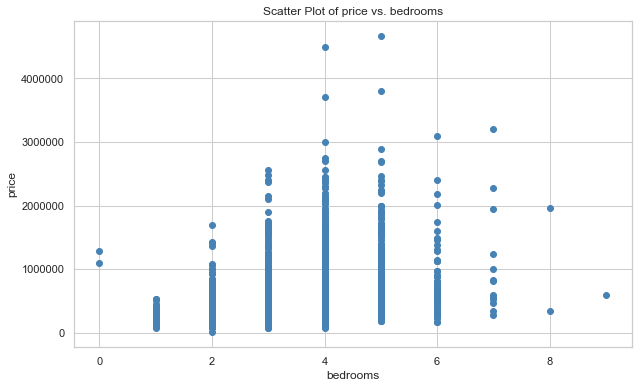

In [43]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.bedrooms, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("bedrooms")
axes.set_title("Scatter Plot of price vs. bedrooms")

plt.show()
plt.close()

The relationship is not clear but we can see price range is wider at around 4-5 bedrooms

#### price v. bathrooms

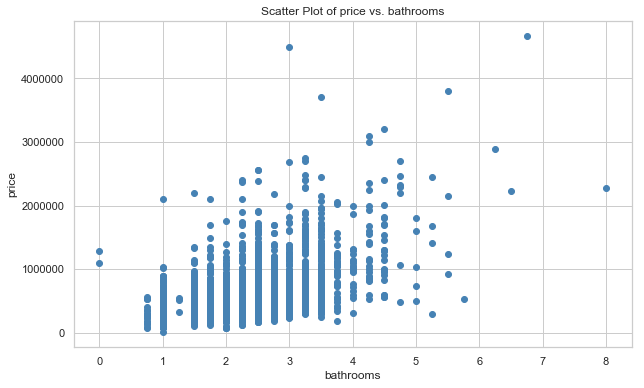

In [44]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.bathrooms, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("bathrooms")
axes.set_title("Scatter Plot of price vs. bathrooms")

plt.show()
plt.close()

There is a weak positive relationship between price and bathrooms

#### price v. sqft_living

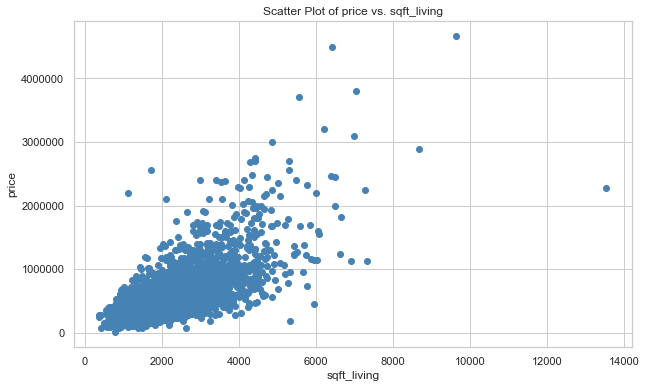

In [45]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.sqft_living, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("sqft_living")
axes.set_title("Scatter Plot of price vs. sqft_living")

plt.show()
plt.close()

There is a positive relationship between price and sqft_living

#### price v. sqft_lot

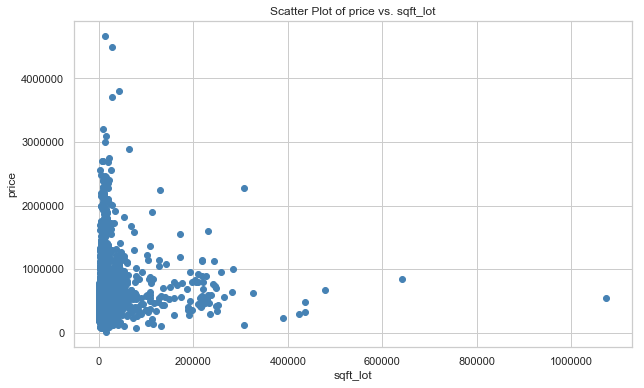

In [46]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.sqft_lot, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("sqft_lot")
axes.set_title("Scatter Plot of price vs. sqft_lot")

plt.show()
plt.close()

There is no clear relatipnship between price and sqft_lot

#### price v. floor

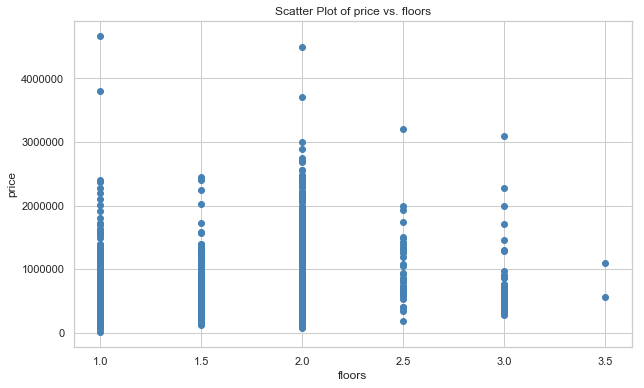

In [47]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.floors, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("floors")
axes.set_title("Scatter Plot of price vs. floors")

plt.show()
plt.close()

The relationship isn't clear but price range seems to be narrower when floors are higher

#### price v. waterfront

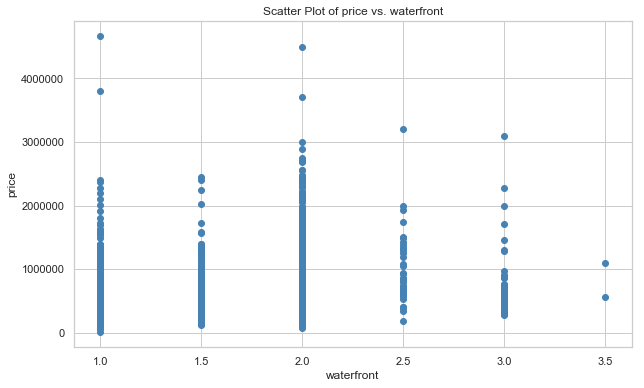

In [48]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.floors, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("waterfront")
axes.set_title("Scatter Plot of price vs. waterfront")

plt.show()
plt.close()

There is no clear relationship between price and waterfront

#### price v. view

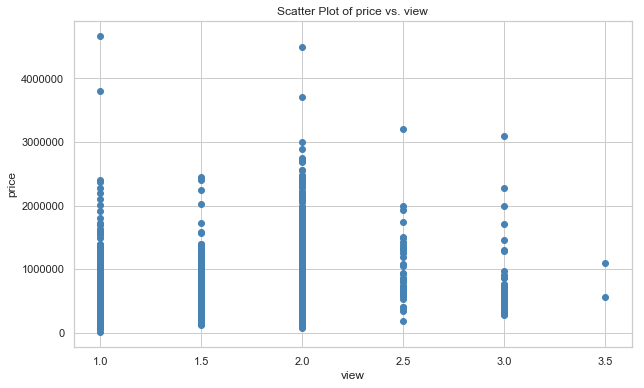

In [49]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.floors, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("view")
axes.set_title("Scatter Plot of price vs. view")

plt.show()
plt.close()

There is no clear relationshi between price and view

#### price v. condition

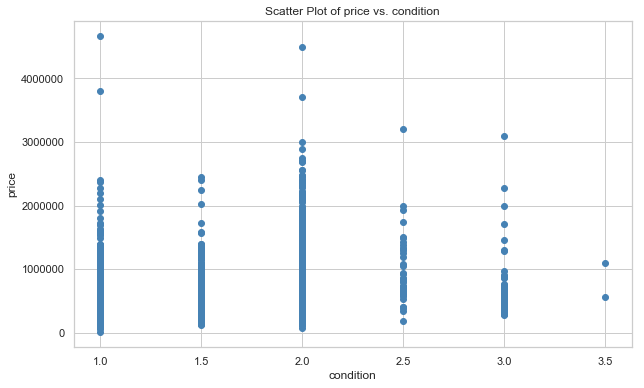

In [50]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.floors, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("condition")
axes.set_title("Scatter Plot of price vs. condition")

plt.show()
plt.close()

There is no clear relationship

#### price v. sqft_above

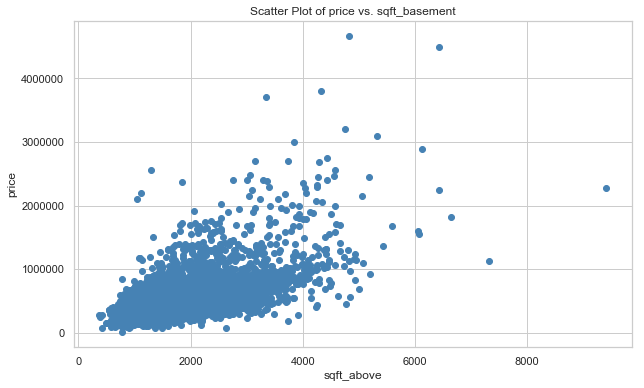

In [51]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.sqft_above, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("sqft_above")
axes.set_title("Scatter Plot of price vs. sqft_basement")

plt.show()
plt.close()

There is apositive relationship between price and sqft_above

#### price v. sqft_basement

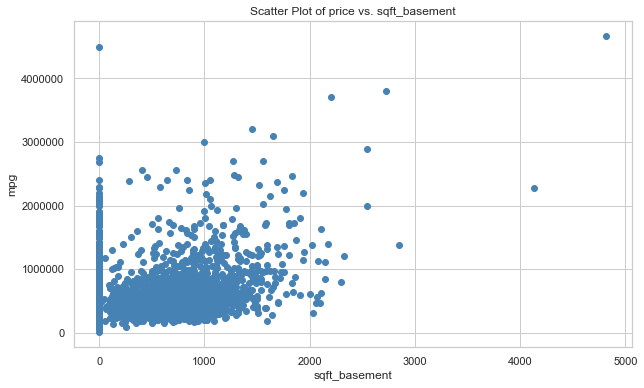

In [52]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.sqft_basement, data.price, marker="o", color="steelblue")

axes.set_ylabel("mpg")
axes.set_xlabel("sqft_basement")
axes.set_title("Scatter Plot of price vs. sqft_basement")

plt.show()
plt.close()

There is a weak positive relationship between price and basement sqft

#### price v. yr_built

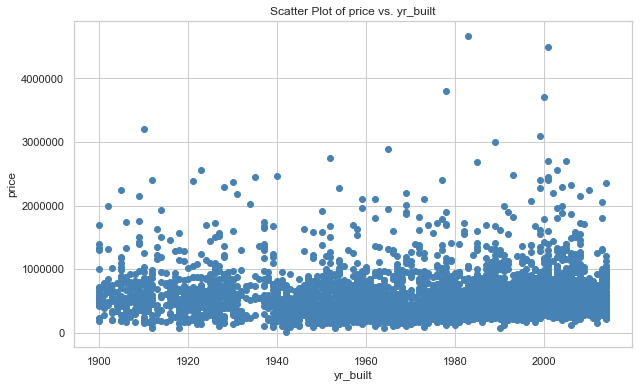

In [53]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.yr_built, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("yr_built")
axes.set_title("Scatter Plot of price vs. yr_built")

plt.show()
plt.close()

There is no clear relationship between yr_built and price

#### longtitude

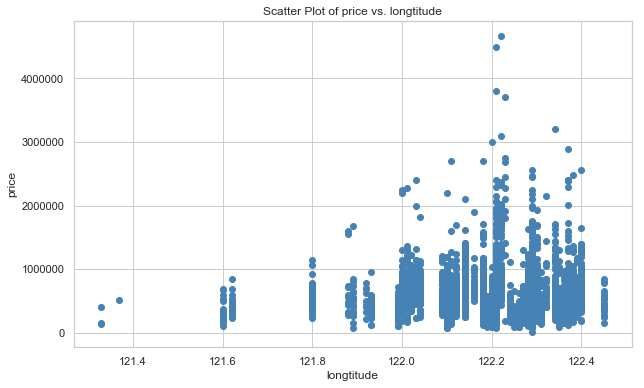

In [54]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.long, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("longtitude")
axes.set_title("Scatter Plot of price vs. longtitude")

plt.show()
plt.close()

There seems to be a peak at price near longtitude 122.2

#### latitude

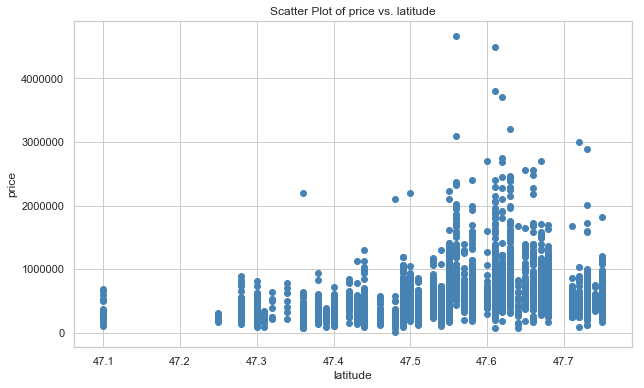

In [55]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.lat, data.price, marker="o", color="steelblue")

axes.set_ylabel("price")
axes.set_xlabel("latitude")
axes.set_title("Scatter Plot of price vs. latitude")

plt.show()
plt.close()

There is a weak positive relationship between price and latitude

<a id="correlations"></a>
### Correlations

Now we will chart the correlations between variables

                  price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
price          1.000000  0.337051   0.529689     0.694739  0.082877  0.261500   
bedrooms       0.337051  1.000000   0.547232     0.597544  0.070897  0.175802   
bathrooms      0.529689  0.547232   1.000000     0.758254  0.109034  0.489644   
sqft_living    0.694739  0.597544   0.758254     1.000000  0.213736  0.344408   
sqft_lot       0.082877  0.070897   0.109034     0.213736  1.000000  0.004061   
floors         0.261500  0.175802   0.489644     0.344408  0.004061  1.000000   
waterfront     0.193942 -0.010504   0.056159     0.087543  0.015983  0.013558   
view           0.383297  0.114235   0.204355     0.307627  0.072237  0.031421   
condition      0.056373  0.023305  -0.120367    -0.061613  0.001042 -0.273748   
sqft_above     0.594288  0.485633   0.686966     0.874284  0.219375  0.523527   
sqft_basement  0.333939  0.334265   0.293756     0.445867  0.035353 -0.256573   
yr_built       0.031033  0.1

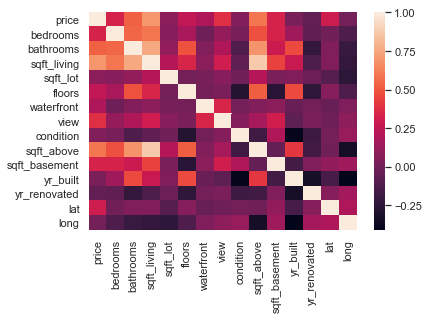

In [56]:
#correlations
corr = data.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Based on the graph above, we see sqft_living an sqft_above has strong positive impact on price whereas bathroom and view have moderate positive impact on price.

In [57]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [58]:
correlations(data, 'price', ["bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","sqft_above","sqft_basement","yr_built","lat","long"])

,feature,r,rho
0,bedrooms,0.337051,0.358877
1,bathrooms,0.529689,0.513608
2,sqft_living,0.694739,0.656484
3,sqft_lot,0.082877,0.083099
4,floors,0.261500,0.328380
5,waterfront,0.193942,0.098351
6,view,0.383297,0.285122
7,condition,0.056373,0.029951
8,sqft_above,0.594288,0.553397
9,sqft_basement,0.333939,0.246249


Referring to chart above, we see the most of the relationships show the same relationship as pairwise analysis and Spearman's  suggests all relationship tends to be linear

Based on our pairwise EDA with the target variable, we predict our features all have positive impact on the price with sqft_living, sqft_above, and bathroom being the main drivers.

<a id="linear"></a>
### Linear Regression Model

before we start, let's look at the null model

In [59]:
data.price.describe()

count    4.548000e+03
mean     5.480383e+05
std      3.553765e+05
min      7.800000e+03
25%      3.260750e+05
50%      4.650000e+05
75%      6.572000e+05
max      4.668000e+06
Name: price, dtype: float64

The lowest price is 7.8e03 and the highest is 4.668e06. The mean is 5.48305 with a standard deviation of 3.55e05. We can think of 3.55e05 as the sigma of the Null model.

Now we can build the first linear model with our "all in" model

In [60]:
model1 = "price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + sqft_above + sqft_basement + yr_built + lat + long"
result1 = models.bootstrap_linear_regression(model1, data)
models.describe_bootstrap_lr(result1)

In [61]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(25,25))

    #variables = ["age", "bmi", "children"]

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

The correlation coefficient R^2 is 63% which is not too good. The error has been cut from Null model's 3.55e05 to model1's 2.17e05. But we have already seen that price is not Normally distributed so the overall error might not be good to use. For coefficients:

* The intercept isn't particularly interesting here because we cannot have features equal to zero for a house
* all features are strong support by data but bedrooms, sqft_lot, and year built are not as expected

Let's look at the residuals:

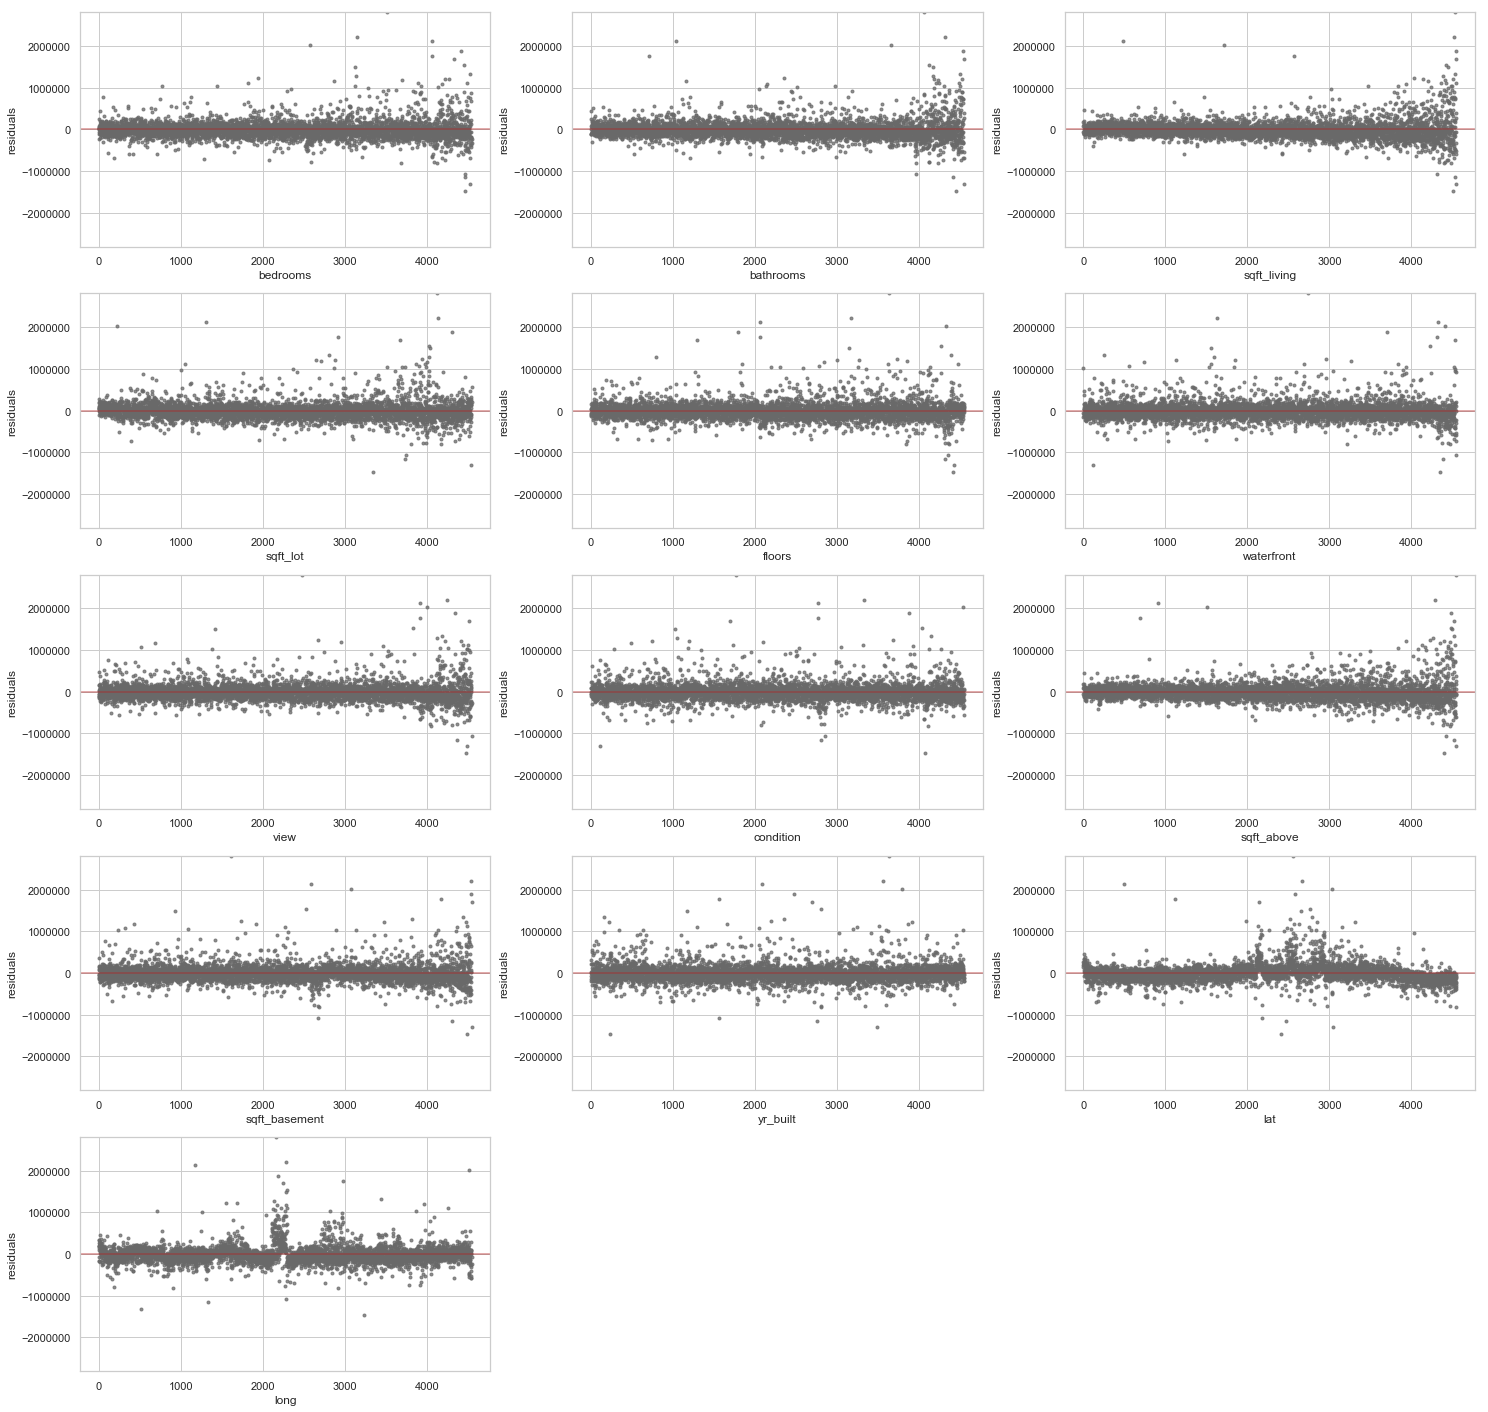

In [62]:
residuals1 = plot_residuals(result1, ["bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","sqft_above","sqft_basement","yr_built","lat","long"])

Most of the graphs are fine but we see patterns in sqft related residual plot. They might need transformation later.

We mentioned before that price is not normally distributed so we would like to resolve that by transform price. Also we see sqft related features have pattern in residuals so we also need to transform them. We would try log transformation for both

In [63]:
data['log_sqft_basement'] = [0 if x == 0 else np.log(x) for x in data['sqft_basement']]

In [64]:
data['sqft_basement'].head()

0       0
1     280
2       0
3    1000
4     800
Name: sqft_basement, dtype: int64

In [65]:
data["log_price"] = data["price"].apply(np.log)
data["log_sqft_living"] = data["sqft_living"].apply(np.log)
data["log_sqft_lot"] = data["sqft_lot"].apply(np.log)
data["log_sqft_above"] = data["sqft_above"].apply(np.log)
data["log_yr_built"] = data["yr_built"].apply(np.log)
data["log_lat"] = data["lat"].apply(np.log)
data["log_long"] = data["long"].apply(np.log)
data["log_lat"] = data["lat"].apply(np.log)
data["log_bedrooms"] = data["bedrooms"].apply(np.log)
data["log_bathrooms"] = data["bathrooms"].apply(np.log)
data["log_floors"] = data["floors"].apply(np.log)
#data["log_sqft_basement"] = data["sqft_basement"].apply(np.log)

In [66]:
model3 = "log_price ~ bedrooms + bathrooms + log_sqft_living + log_sqft_lot + floors + waterfront + view + condition + log_sqft_above+ log_sqft_basement + log_yr_built +lat + long"
result3 = models.bootstrap_linear_regression(model3, data)
models.describe_bootstrap_lr(result3)

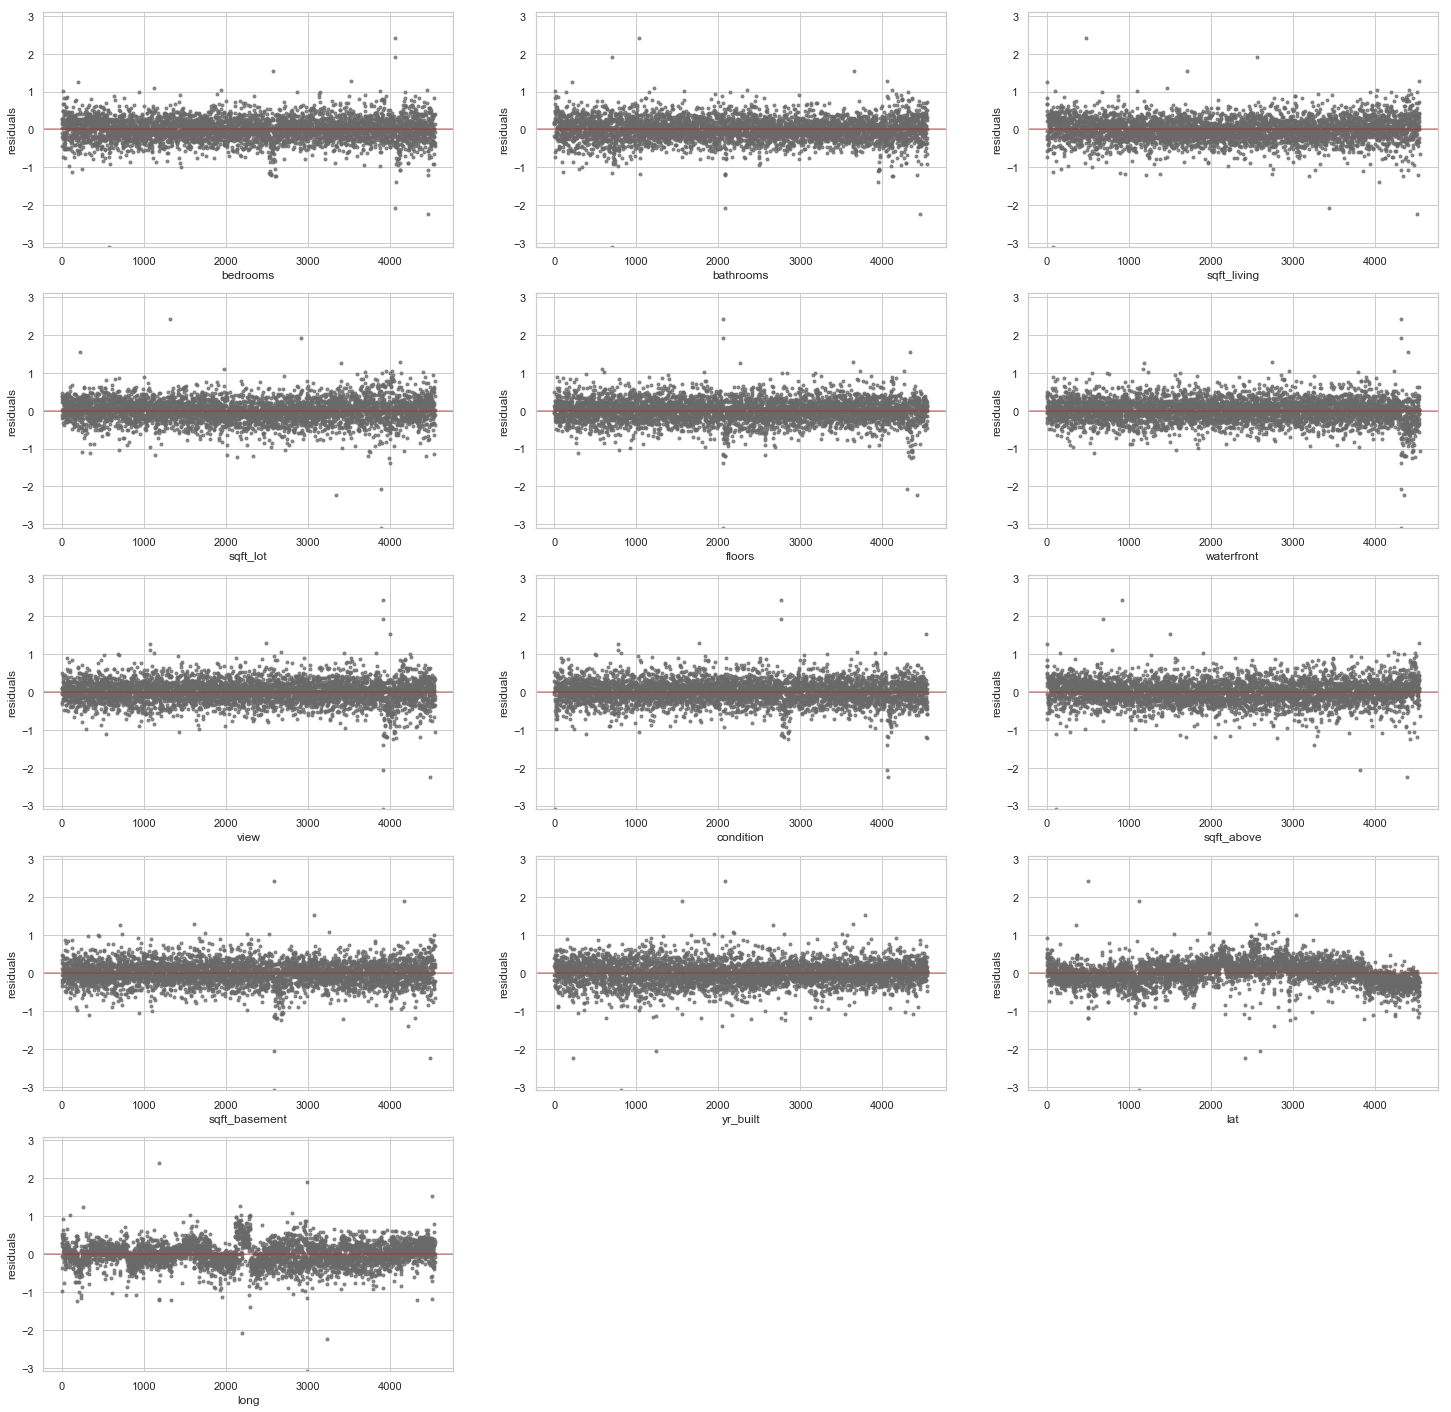

In [67]:
residuals3 = plot_residuals(result3, ["bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","sqft_above","sqft_basement","yr_built","lat","long"])

Our errors are much more symmetric now

Now let's evaluate if adding interaction team can further improve our model

In [68]:
model4 = "log_price ~ bedrooms + bathrooms + log_sqft_living + log_sqft_lot + floors + waterfront + view + condition + log_sqft_above+ log_sqft_basement + log_yr_built +lat + long +lat:long"
result4 = models.bootstrap_linear_regression(model4, data)
models.describe_bootstrap_lr(result4)

In [69]:
model5 = "log_price ~ bedrooms + bathrooms + log_sqft_living + log_sqft_lot + floors + waterfront + view + condition + log_sqft_above+ log_sqft_basement + log_yr_built +lat + long +floors:bedrooms"
result5 = models.bootstrap_linear_regression(model5, data)
models.describe_bootstrap_lr(result5)

In [70]:
model6 = "log_price ~ bedrooms + bathrooms + log_sqft_living + log_sqft_lot + floors + waterfront + view + condition + log_sqft_above+ log_sqft_basement + log_yr_built +lat + long +sqft_living:floors"
result6 = models.bootstrap_linear_regression(model6, data)
models.describe_bootstrap_lr(result6)

Adding interation term doesn't seem to improve our model. Therefore, we will finalize our model as below

<a id="evaluation"></a>
### Linear Regression Model Evaluation

In [71]:
from collections import defaultdict

In [72]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics
#

def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

Here we will perform three rounds of 10-fold cross validation and calculate 95% Bootstrap estimates of the credible intervals for R^2 and sigma

In [73]:
formula = model3

In [74]:
validationresult = cross_validation(models.linear_regression, formula, data, lambda r: (r["sigma"], r["r_squared"]))

In [75]:
sigmas = [r[0] for r in validationresult]
r_squareds = [r[1] for r in validationresult]

In [76]:
print("mean sigma: ", np.mean(sigmas))
print("mean R^2: ", np.mean(r_squareds))

mean sigma:  0.3085314815767892
mean R^2:  0.6768043607834913


In [77]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [78]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [79]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [0.30325701 0.31385436]


In [80]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.66756644 0.68748345]


In [81]:

result = learning_curves(models.linear_regression, formula, data, lambda r: r["sigma"])

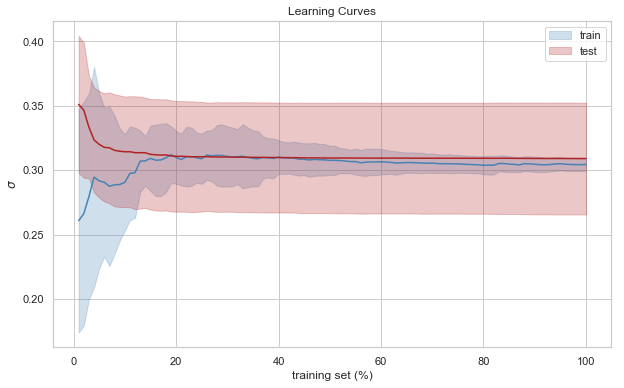

In [82]:
plot_learning_curves(result, r"$\sigma$")

Based on the graph above, we can see our model is in a high bias low variance state so adding more data is not likely to improve the model.

<a id="tree"></a>
### Decision Tree

As the linear regression results are not ideal, we will now try solve this problem using deicsion tree

In [83]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    
def rmse( y, y_hat):
    return np.sqrt((1.0/len( y)) * np.sum((y - y_hat)**2))

# Import train_test_split function
from sklearn.model_selection import train_test_split

In [84]:


features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','sqft_above','sqft_basement','yr_built','lat','long']

# Train, test, split the data
X = data[features] # Features
y = data['price'] # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 80% training and 20% test

# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

#Train the model using the training sets 
regressor.fit(X_train,y_train)
y_true = np.array(y_test)
y_pred = regressor.predict(X_test)

# Print Evaluation Metrics
from sklearn.metrics import r2_score,mean_squared_error
print(r2_score(y_true, y_pred))
#mse
print(np.sqrt(mean_squared_error(y_true, y_pred)))

0.49584806710877416
238230.45538515667


The current Decision Tree Regression without figuring out the best tree depth is actually doing worse than Linear Regression Model, so now let's find out the best tree depth with validation curve.

In [85]:
def validation_curve(seed, X, y, min_depth, max_depth, test_size=0.20):
    train_scores = []
    test_scores = []
    
    for i in range(min_depth, max_depth + 1):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        
        reg = DecisionTreeRegressor(random_state=seed, max_depth=i)
        
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_train)
        train_scores.append(rmse(y_train, y_pred))
        
        y_pred = reg.predict(X_test)
        test_scores.append(rmse(y_test, y_pred))
        
    return train_scores, test_scores

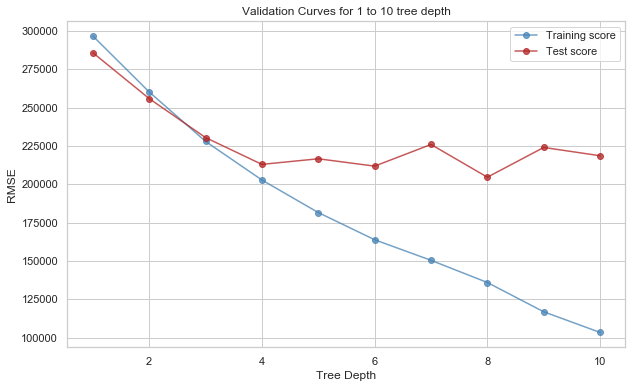

In [86]:
min_depth = 1
max_depth = 10
param_range = range(min_depth, max_depth + 1)
x_label = 'Tree Depth'
y_label = 'RMSE'
title = "Validation Curves for {0} to {1} tree depth".format(min_depth, max_depth)

train_scores, test_scores = validation_curve(0, X, y, min_depth, max_depth)

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(param_range, train_scores, 'o-', color="steelblue", alpha=0.75, label="Training score")
axes.plot(param_range, test_scores, "o-", color="firebrick", alpha=0.75, label="Test score")
axes.set_xlabel(x_label)
axes.set_ylabel(y_label)
axes.set_title(title)
plt.legend(loc="best")
plt.show()
plt.close()

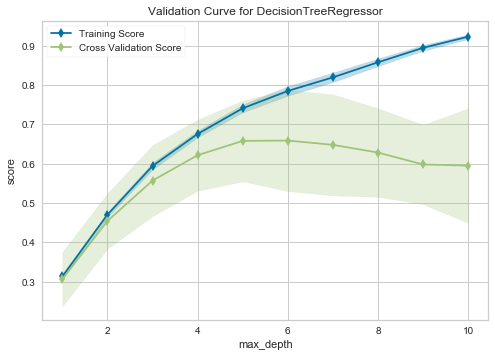

In [87]:
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    DecisionTreeRegressor(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

It looks like tree depth of 5 is the sweet spot for best bias/variance trade off, as we increase tree depth we tend to overfit the model.

Let's rebuild the model with optimal depth

In [88]:
seed = 101
regressor2 = DecisionTreeRegressor(max_depth =5)
regressor2.fit(X_train, y_train)

y_pred = regressor2.predict(X_test)

df = pd.DataFrame({'Actual': y_test,'Predicted':y_pred})
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10, random_state=seed)
results = model_selection.cross_val_score(regressor2, X, y, cv=kfold)
print("R^2")
print(results.mean())
#from sklearn.metrics import r2_score
#r2_score(y_test, y_pred) 

R^2
0.6599795164120981


Now the result is much better and close to the linear regression model

Let's visualize the decision tree

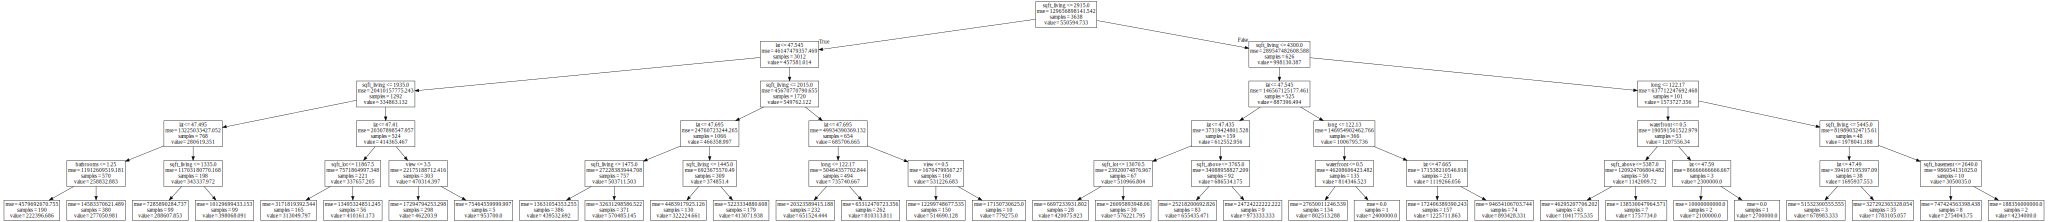

In [89]:
from graphviz import Source
from IPython.display import SVG
from IPython.display import display
from sklearn import tree

import os
os.environ["PATH"] += os.pathsep + 'D:/graphviz/bin/'

graph = Source(tree.export_graphviz(regressor2,out_file = None, filled = None, feature_names = features))
display(SVG(graph.pipe(format = 'svg')))

In [90]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    from sklearn.model_selection import learning_curve
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.25,
                     color="steelblue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.25, color="firebrick")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="firebrick",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    plt.close()

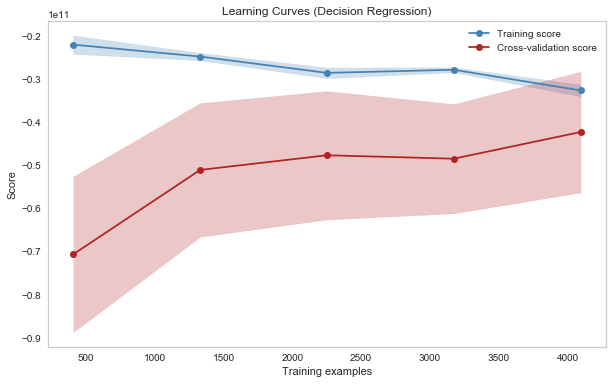

In [91]:
seed = 101
title = "Learning Curves (Decision Regression)"
estimator = DecisionTreeRegressor(random_state=seed, max_depth=5)
plot_learning_curve(estimator, title, X, y, cv=10, n_jobs=1)

Based on the learning curve, more data seems to be able to further improve the accuracy of the model

<a id="forest"></a>
### Random Forest

Now we will try to see if a better model can be generated using random forest

In [92]:
# Helper functions
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    
def rmse( y, y_hat):
    return np.sqrt((1.0/len( y)) * np.sum((y - y_hat)**2))

# Import train_test_split function
from sklearn.model_selection import train_test_split

#### Build Random Forest Model

In [93]:
seed = 101
set_seed(seed)

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','sqft_above','sqft_basement','yr_built','lat','long']

# Train, test, split the data
X = data[features] # Features
y = data['price'] # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestRegressor(random_state=seed)

#Train the model using the training sets 
rfc.fit(X_train,y_train)
y_true = np.array(y_test)
y_pred = rfc.predict(X_test)

# Print Evaluation Metrics
print('Decision Tree Regressor,  R^2: %f' % rfc.score(X_test, y_test))
print('Decision Tree Regressor, RMSE: %f' % rmse(y_true, y_pred))

Decision Tree Regressor,  R^2: 0.729102
Decision Tree Regressor, RMSE: 192878.631008


In [94]:
def validation_curve(seed, X, y, min_val, max_val, step, test_size=0.20):
    train_scores = []
    test_scores = []
    
    for i in range(min_val, max_val + 10):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        reg = RandomForestRegressor(random_state=seed, n_estimators=i)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_train)
        train_scores.append(rmse(y_train, y_pred))
        y_pred = reg.predict(X_test)
        test_scores.append(rmse(y_test, y_pred))
    return train_scores, test_scores

seed = 101
min_val = 10
max_val = 100
step = 10
param_range = range(min_val, max_val + step)
x_label = 'No. of Trees in RandomForest'
y_label = 'RMSE'
title = "Validation Curves for {0} to {1} trees in forest".format(min_val, max_val)

train_scores, test_scores = validation_curve(seed, X, y, min_val, max_val, step=200)

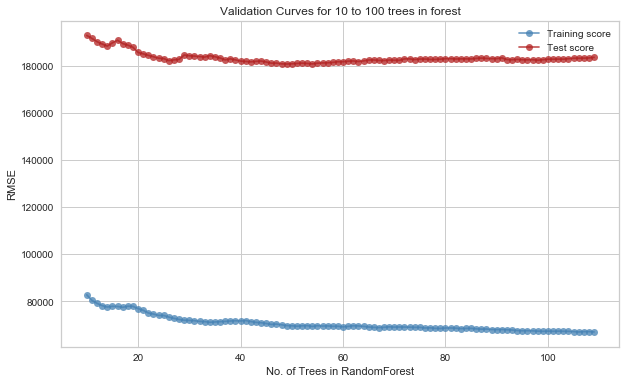

In [95]:
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(param_range, train_scores, 'o-', color="steelblue", alpha=0.75, label="Training score")
axes.plot(param_range, test_scores, "o-", color="firebrick", alpha=0.75, label="Test score")
axes.set_xlabel(x_label)
axes.set_ylabel(y_label)
axes.set_title(title)
plt.legend(loc="best")
plt.show()
plt.close()

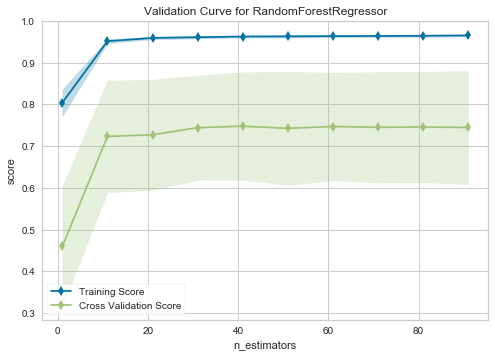

In [96]:
from sklearn.ensemble import RandomForestRegressor
viz = ValidationCurve(RandomForestRegressor(), param_name="n_estimators",
    param_range=np.arange(1,100,10), cv=10, scoring="r2")
# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

Based on the validation curve, 50 trees seems give the best score

Let's adjust the hyperparameter for this

In [97]:
seed = 101
set_seed(seed)

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','sqft_above','sqft_basement','yr_built','lat','long']

# Train, test, split the data
X = data[features] # Features
y = data['price'] # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestRegressor(n_estimators = 50, random_state=seed)

#Train the model using the training sets 
rfc.fit(X_train,y_train)
y_true = np.array(y_test)
y_pred = rfc.predict(X_test)

# Print Evaluation Metrics
print('Decision Tree Regressor,  R^2: %f' % rfc.score(X_test, y_test))
print('Decision Tree Regressor, RMSE: %f' % rmse(y_true, y_pred))

Decision Tree Regressor,  R^2: 0.761784
Decision Tree Regressor, RMSE: 180870.064630


The R^2 of the model is 0.76 now which is the best among all models so far.

#### Feature Importance

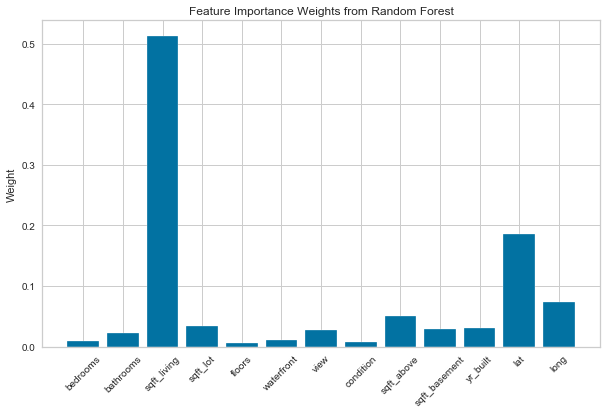

In [98]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)



axes.bar(list(range(0, len(features))), rfc.feature_importances_)
axes.set_xticks(np.arange(len(features)))
axes.set_xticklabels(features, rotation = 45)

axes.set_ylabel("Weight")
axes.set_title("Feature Importance Weights from Random Forest")

plt.show()
plt.close()

Here we can see sqft_living is the the most important factors followed by latitude and longtituude with is align with our linear regression model results.

<a id="summary"></a>
### Executive Summary

In this analysis, we examined the house price data by conducting single variable analysis, pairwise variable analysis, and correlations. To further understand the relationship between price and other variables, we built several models to predict the price of a house based on different varaibles using regression and machine learning models such as linear regression, decision trees,and random forests.

As a result, the random forest model gives us the best R^2 76% in terms of predicting the house price as well as identifies sqft living and location (i.e. latitude and longtitude) as the most important factors drive the housing price.